- environment file (min setup)
- put dataset on hydroshare
    - test: spi180d over Washington
- setup cell that pulls data from hydroshare and goes through basic functionality of package
    - runs through creating the network
    - few cells that show some plotting
- well documented notebook & functions

# ndrought Tutorial
a. stein 8.1.2023

## Setup

In [1]:
import numpy as np

import sys
import os
sys.path.append('../../')
import ndrought.drought_network_v12 as dnet
import ndrought.wrangle_v11 as dnw

import matplotlib as mpl
import matplotlib.pyplot as plt

import pandas as pd
import xarray as xr

from tqdm.autonotebook import tqdm

from dask.distributed import Client, LocalCluster, wait
import dask

/pool0/data/steinjao/drought/drought_impact/notebooks/tutorial/../../ndrought/wrangle_v11.py:18: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from tqdm.autonotebook import tqdm


Download Data

In [2]:
if not os.path.exists('spi180d_tutorial.nc'):
    !wget https://www.hydroshare.org/resource/1ca38699cd1245b8bf9baf52bc99b85d/data/contents/spi180d_tutorial.nc

Read in data

In [3]:
spi_180d = xr.open_dataset('spi180d_tutorial.nc')
spi_180d

<xarray.Dataset>
Dimensions:  (lat: 84, lon: 188, day: 1533)
Coordinates:
  * lat      (lat) float64 48.98 48.94 48.9 48.86 ... 45.65 45.61 45.57 45.53
  * lon      (lon) float64 -124.7 -124.7 -124.6 -124.6 ... -117.0 -117.0 -116.9
  * day      (day) datetime64[ns] 2000-01-05 2000-01-10 ... 2020-12-30
Data variables:
    crs      int64 ...
    spi      (day, lat, lon) float32 ...

In [4]:
spi_180d_da = spi_180d['spi'].rename({'day':'time'})
spi_180d_da

<xarray.DataArray 'spi' (time: 1533, lat: 84, lon: 188)>
[24209136 values with dtype=float32]
Coordinates:
  * lat      (lat) float64 48.98 48.94 48.9 48.86 ... 45.65 45.61 45.57 45.53
  * lon      (lon) float64 -124.7 -124.7 -124.6 -124.6 ... -117.0 -117.0 -116.9
  * time     (time) datetime64[ns] 2000-01-05 2000-01-10 ... 2020-12-30
Attributes:
    units:              
    description:        Standardized Precipitation Index
    long_name:          spi180d
    standard_name:      spi180d
    dimensions:         lon lat time
    coordinate_system:  WGS84,EPSG:4326
    Clipping:           original data was clipped to Washington using http://...
    grid_mapping:       crs

## Convert to USDM Categories

D0 : 21 to 30 p    
D1 : 11 to 20 p    
D2 : 6 to 10 p    
D3 : 3 to 5 p    
D4 : 0 to 2 p

In [5]:
percentiles = [30, 20, 10, 5, 2]
if not os.path.exists('spi180d_usdmcat.nc'):
    # note that this can take about 2 minutes to run
    spi_180d_usdmcat = dnw.dm_to_usdmcat_multtime(spi_180d_da, percentiles)
    spi_180d_usdmcat.to_netcdf('spi180d_usdmcat.nc')
else:
    spi_180d_usdmcat = xr.open_dataset('spi180d_usdmcat.nc')['spi']

Now we can check that our values are in USDM Categories through a little histogram:

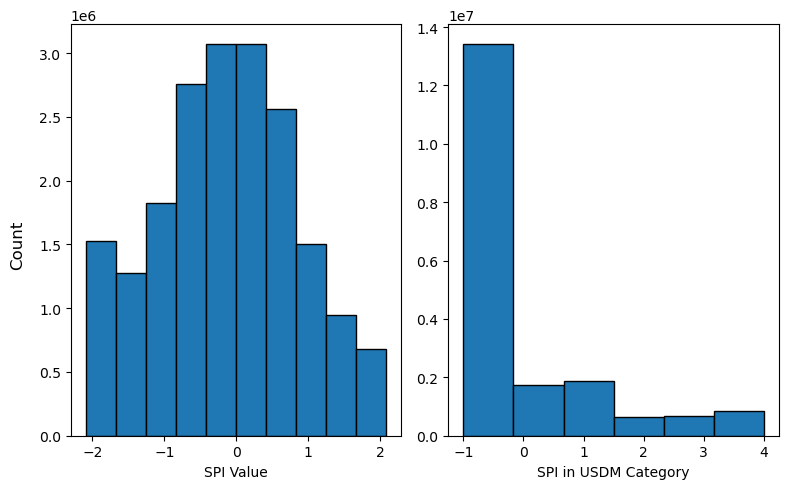

In [6]:
fig, axs = plt.subplots(1, 2, figsize=(8,5))

axs[0].hist(spi_180d_da.values.ravel(), edgecolor='k')
axs[1].hist(spi_180d_usdmcat.values.ravel(), bins=6, edgecolor='k')

fig.supylabel('Count')
axs[0].set_xlabel('SPI Value')
axs[1].set_xlabel('SPI in USDM Category')

plt.tight_layout()

Now we need to reproject to an Albers Equal Area projection for doing computations on drought area that is creating the drought network and extracting drought tracks.

First off, since we have a dataarray, we need to write it's crs

In [7]:
spi_180d.crs.attrs['crs_wkt']

'GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AXIS["Latitude",NORTH],AXIS["Longitude",EAST],AUTHORITY["EPSG","4326"]]'

We can see that EPSG:4326 was the last projection this was converted to, so let's write that down.

In [8]:
spi_180d_usdmcat = spi_180d_usdmcat.rio.write_crs('EPSG:4326', inplace=True)

Now I want to reproject it to EPSG:5070 to have an Albers Equal Area projection over Washington state.

In [9]:
spi_180d_usdmcat_reproj = spi_180d_usdmcat.rio.reproject('EPSG:5070')

Let's save that out

In [10]:
# need to remove this grid_mapping 
# attribute for the function to save out properly
del spi_180d_usdmcat_reproj.attrs['grid_mapping']
# also need to remove the crs we just assigned it to 
# preserve the netcdf as a singular variable that
# our drought tracks will want later
del spi_180d_usdmcat_reproj['crs']
if not os.path.exists('spi180d_usdmcat_EPSG5070.nc'):
    spi_180d_usdmcat_reproj.to_netcdf('spi180d_usdmcat_EPSG5070.nc')

Wonderful. Now that we have that sorted we can move on to creating our drought network.

## Create Drought Network

Let's compute how big a cell is

In [11]:
spi_180d_usdmcat_reproj.x.attrs['units']

'metre'

In [12]:
x_spacing = np.abs(spi_180d_usdmcat_reproj.x.values[1] - spi_180d_usdmcat_reproj.x.values[0])/1e3 #km
x_spacing

3.4502829917380584

In [13]:
y_spacing = np.abs(spi_180d_usdmcat_reproj.y.values[1] - spi_180d_usdmcat_reproj.y.values[0])/1e3 # km
y_spacing

3.4502829917380584

In [14]:
cell_area = np.round(np.abs(x_spacing*y_spacing), 1)
cell_area

11.9

Computing the drought network takes an area threshold in number of cells, so we need to divide whatever our desired area is in square-kilometers by our cell area to get the number of cells we need to set our threshold at.

In [15]:
# adding one since I want to round up
area_threshold = np.int64(25000/cell_area)+1 
area_threshold

2101

Now we can create our drought network. Notice that we can save these out in a pickle for easy access later.

In [16]:
# around 3 minutes to run if area threshold is 25000 km2
if not os.path.exists('spi180d_dnet.pickle'):
    spi180d_dnet = dnet.DroughtNetwork(spi_180d_usdmcat_reproj.values, area_threshold=area_threshold)
    spi180d_dnet.pickle('spi180d_dnet.pickle')
else:
    spi180d_dnet = dnet.DroughtNetwork.unpickle('spi180d_dnet.pickle')

## Extract Drought Tracks

### Create Configuration file

In [17]:
config_path = 'tutorial_config.yaml'
track_path = 'spi180d_tracks.pickle'

if not os.path.exists(config_path):
    dnw.write_config(
            config_path='tutorial_config.yaml',
            data_dir='spi180d_usdmcat_EPSG5070.nc',
            dnet_dir='spi180d_dnet.pickle',
            track_dir=track_path,
            log_dir='tutorial_logs',
            metric_thresh=1,
            area_thresh=area_threshold,
            ratio_thresh=0.2
        )

### Create a dask client for parallelism

In [18]:
cluster = LocalCluster(n_workers=4, threads_per_worker=1)

client = Client(cluster)
print(client.dashboard_link)

/pool0/data/steinadi/.conda/envs/ndrought/lib/python3.11/site-packages/distributed/node.py:182: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 40367 instead
  warnings.warn(


http://127.0.0.1:40367/status


### Extract our tracks from the network

In [19]:
dnw.compute_drought_tracks(config_path, client)

Lazy Data Load
... Data ready


So what did we just create? We extracted the following attributes as tracks:
- x coordinate
- y coordinate
- u vector
- v vector
- time coordinate
- color as a function of relative time
- transparency as a function of similarity
- size of blobs at x,y
- size of blobs at x+u, y+v

With this we can compute a variety of statistics about our drought metric

### Read in our tracks

Here we have our drought-track-dictionary, or dtd for short

In [20]:
spi180d_dtd = dnw.convert_pickle_to_dtd(track_path)

I'm going to prune the tracks so that we only have one track per termination point, e.g. enforcing our singular-termination point filter as described in the paper.

In [21]:
spi180d_dtd = dnw.prune_tracks(spi180d_dtd)

Let's take a look at our keys we get

In [22]:
spi180d_dtd.keys()

dict_keys(['x', 'y', 'u', 'v', 't', 'c', 'a', 's', 'sf'])

Each key corresponds to the list previously mentioned:
- x : x coordinate
- y : y coordinate
- u : u vector
- v : v vector
- t : time coordinate
- c : color as a function of relative time
- a : transparency as a function of similarity
- s : size of blobs at x,y
- sf : size of blobs at x+u, y+v

The dictionary is composed of a list of tracks that follow the same order for each key. So if I wanted to get the x,y coordinates of the first track listed, I'd do:

In [23]:
[(x, y) for x, y in zip(spi180d_dtd['x'][0], spi180d_dtd['y'][0])]

[(-1785337.6354301653, 2856081.7167596617)]

Which happens to be a singular element

And if I call `len` on one of the dtd lists, then I can see how many tracks there are

In [24]:
len(spi180d_dtd['x'])

43

If we want our basic summary statistics described in the paper (lifetime, distance, displacement, average velocity, similarity, size), we can use a summarizing function:

In [25]:
# need to pass in how many days per time increment.
# for spi it's pentads, or 5 days
spi180d_summary, spi180d_summary_grouped = dnw.compute_track_summary_characterization(spi180d_dtd, 5)

In [26]:
spi180d_summary.head()

,lifetime,distance,displacement,average velocity,similarity,xy_size,uv_size
0,0,5519.004667,5519.004667,inf,0.901313,[2128],[2361]
1,0,13865.557998,13865.557998,inf,0.920949,[3036],[2796]
2,245,671580.701035,131290.457655,2741.145719,0.933859,"[6389, 9830, 10021, 9201, 11104, 12850, 12705,...","[9830, 10021, 9201, 11104, 12850, 12705, 12726..."
3,10,55379.685618,34973.811416,5537.968562,0.676662,"[2696, 3684, 2185]","[3684, 2185, 3099]"
4,0,41145.413395,41145.413395,inf,0.583619,[4383],[2558]


The second output from that function is a groupby object grouped by `[0, 30, 60, 90, 180, 365, 730, 1825, 7*1163]`

In [27]:
spi180d_summary_grouped

That way we can do things like get the mean lifetime per temporal bin:

In [28]:
spi180d_summary_grouped['lifetime'].mean()

lifetime
(0, 30]          17.000000
(30, 60]         40.833333
(60, 90]         67.500000
(90, 180]       143.125000
(180, 365]      260.000000
(365, 730]             NaN
(730, 1825]            NaN
(1825, 8141]           NaN
Name: lifetime, dtype: float64

Now what if we want to get latitudes and longitudes out of our tracks instead? Well we can use `dnw.transform_points`

In [29]:
dnw.transform_points?

Signature:
dnw.transform_points(
    x,
    y,
    inproj=<Projected CRS: EPSG:5070>
Name: NAD83 / Conus Albers
Axis Info [cartesian]:
- X[east]: Easting (metre)
- Y[north]: Northing (metre)
Area of Use:
- name: United States (USA) - CONUS onshore - Alabama; Arizona; Arkansas; California; Colorado; Connecticut; Delaware; Florida; Georgia; Idaho; Illinois; Indiana; Iowa; Kansas; Kentucky; Louisiana; Maine; Maryland; Massachusetts; Michigan; Minnesota; Mississippi; Missouri; Montana; Nebraska; Nevada; New Hampshire; New Jersey; New Mexico; New York; North Carolina; North Dakota; Ohio; Oklahoma; Oregon; Pennsylvania; Rhode Island; South Carolina; South Dakota; Tennessee; Texas; Utah; Vermont; Virginia; Washington; West Virginia; Wisconsin; Wyoming.
- bounds: (-124.79, 24.41, -66.91, 49.38)
Coordinate Operation:
- name: Conus Albers
- method: Albers Equal Area
Datum: North American Datum 1983
- Ellipsoid: GRS 1980
- Prime Meridian: Greenwich
,
    outproj=<Geographic 2D CRS: EPSG:4326>
Nam

We can see the default arguments are expecting coordinates of `EPSG:5070` and tranforming them into `EPSG:4326`, but we could replace them with any projections.

In [30]:
lat, lon = dnw.transform_points(spi180d_dtd['x'][0], spi180d_dtd['y'][0])
print(lat, lon)

[46.69779135] [-119.49753271]


/pool0/data/steinjao/drought/drought_impact/notebooks/tutorial/../../ndrought/wrangle_v11.py:985: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  return pyproj.transform(inproj,outproj,x,y)
